In [3]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(berlin_now)

2023-05-16 14:09:52.590355+02:00


# 0. import libraries, general settings

In [4]:
# first mute future warnings and only then import pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy
import pandas as pd
import os
import scanpy as sc
import ast
import matplotlib.colors as colors_mat
import matplotlib.patches as mpatches

from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from tqdm import tqdm
from IPython import display
from scipy.stats import hypergeom

## Import and processing of Spongilla single cell data

In [2]:
# adata = sc.read_loom("/g/arendt/data/spongilla_singlecell_dataset/UCSC_files/spongilla_seurat_object_corrected.loom", sparse=True)
# adata.write("../data/spongilla_basic.h5ad")
adata = sc.read('../data/spongilla_basic.h5ad')

In [3]:
numbers = ['2', '3', '6', '7', '12', '13', '14', '15', '16', '17', '19', '20', '23', '26', '29', '32', '34', '38', '42']
keep = ~adata.obs['cell_type'].isin(numbers)
adata = adata[keep].copy()

In [4]:
celltypes_by_family = [
    'Incurrent Pinacocytes1', 'Incurrent Pinacocytes2',
    'Apendopinacocytes1', 'Apendopinacocytes2', 'Lophocytes', 'Basopinacocytes', 'Sclerophorocytes', 'Metabolocytes1',
    'Metabolocytes2', 'Choanoblasts1', 'Choanoblasts2', 'Choanocytes', 'Apopylar Cells', 
    'Myopeptidocytes1', 'Myopeptidocytes2', 'Amoebocytes', 'Granulocytes', 'Neuroid', 'Mesocytes 1',
    'Mesocytes 2', 'Mesocytes 3', 'Archaeocytes', 'Sclerocytes'
]

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize first

adata.raw = adata #safe normalized, non log counts in raw

sc.pp.log1p(adata) #log scale the counts. This way both raw (normalized) and log scaled counts can be used for the dotplots.

# 1. GO-Enrichment of Proteomic results

For GO enrichment we are using GOATOOLS (https://github.com/tanghaibao/goatools). This tools allows the usage of custom GO term mappings. This is important in the light of non-model species because there are no experimental GO assignments available. One of the most widely used tools for automated proteome annotation is e-mapper (EggNOG mapper). For more details, please refer to the methods section of the manuscript.

## 1.1 GO Enrichment of Secretomic results

### 1.1.1 GO Enrichment proteins with predicted signal sequence

The very first thing to check is, if secreted proteins do have a signal peptide. With this, we want to lower the chance of finding random proteins in the supernatant that for example only were found because of ruptured cells, etc. 

We used the SignalP 6.0 web server (https://services.healthtech.dtu.dk/service.php?SignalP-6.0) with the whole sponge proteome to predict signal sequences. After that, kept all proteins with a signal peptide prediction > 0.9. We were left with around 840 unique gene names. To investigate the usefulness of this analysis, we did a GO enrichment of this list against all sponge proteins:

In [5]:
fin_study = '../data/GO_analysis/Go_targets/secreted_proteins_signalP_0.9.list'         # Study genes
fin_pop   = '../data/GO_analysis/GO_background/full_unique_gene_names.list'  # Population genes
fin_obo   = '../data/GO_analysis/go-basic.obo'             # DAG containing HPO terms
fin_anno  = '../data/GO_analysis/GO_mapping/gene_to_GO.list' # Annotation of genes-to-HPO terms

In [6]:
from goatools.utils import read_geneset

study_ids = read_geneset(fin_study)
population_ids = read_geneset(fin_pop)

      893 READ: ../data/GO_analysis/Go_targets/secreted_proteins_signalP_0.9.list
   24,470 READ: ../data/GO_analysis/GO_background/full_unique_gene_names.list


In [7]:
from goatools.obo_parser import GODag

godag = GODag(fin_obo)

../data/GO_analysis/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms


In [ ]:
from goatools.anno.idtogos_reader import IdToGosReader

annoobj = IdToGosReader(fin_anno, godag=godag)

id2gos = annoobj.get_id2gos()

In [9]:
from goatools.go_enrichment import GOEnrichmentStudy

goeaobj = GOEnrichmentStudy(
    population_ids,
    annoobj.get_id2gos(),
    godag,
    methods=['bonferroni', 'fdr_bh'],
    pvalcalc='fisher_scipy_stats')

9721 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 40%  9,721 of 24,470 population items found in association


In [10]:
results = goeaobj.run_study_nts(study_ids)


Runing  Ontology Analysis: current study set of 893 IDs.
 43%    385 of    893 study items found in association
100%    893 of    893 study items found in population(24470)
Calculating 19,581 uncorrected p-values using fisher_scipy_stats
  19,581 terms are associated with  9,721 of 24,470 population items
   6,547 terms are associated with    385 of    893 study items
  METHOD bonferroni:
     246 GO terms found significant (< 0.05=alpha) (205 enriched +  41 purified): local bonferroni
     362 study items associated with significant GO IDs (enriched)
     226 study items associated with significant GO IDs (purified)
  METHOD fdr_bh:
     973 GO terms found significant (< 0.05=alpha) (847 enriched + 126 purified): statsmodels fdr_bh
     379 study items associated with significant GO IDs (enriched)
     259 study items associated with significant GO IDs (purified)


In [11]:
columns = ['namespace', 'term_id', 'name', 'e/p', 'pval_uncorr', 'Benjamimi/Hochberg', 'Bonferroni', 'study_ratio', 'population_ratio', 'study_items']
GO_enrichments = pd.DataFrame(columns = columns)
length = len(results)
for column in columns:
        GO_enrichments[column] = [''] * length
for i, ntd in enumerate(sorted(results, key=lambda nt: [nt.p_uncorrected, nt.GO])):
    GO_enrichments['namespace'][i] = ntd.NS
    GO_enrichments['term_id'][i] = ntd.GO
    GO_enrichments['name'][i] = ntd.name
    GO_enrichments['e/p'][i] = ntd.enrichment
    GO_enrichments['study_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_study)
    GO_enrichments['population_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_pop)
    GO_enrichments['pval_uncorr'][i] = ntd.p_uncorrected
    GO_enrichments['Bonferroni'][i] = ntd.p_bonferroni
    GO_enrichments['Benjamimi/Hochberg'][i] = ntd.p_fdr_bh
    GO_enrichments['study_items'][i] = ntd.study_items

In [12]:
GO_enrichments = GO_enrichments[GO_enrichments['e/p'] == 'e']
GO_enrichments = GO_enrichments[GO_enrichments['Benjamimi/Hochberg'] < 0.001]

In [13]:
GO_enrichments['fold_enrichment'] = len(GO_enrichments) * ['']
for index, row in GO_enrichments.iterrows():
    study_ratio_true = int(row['study_ratio'].split('/')[0])
    study_ratio_all = int(row['study_ratio'].split('/')[1])
    population_ratio_true = int(row['population_ratio'].split('/')[0])
    population_ratio_all = int(row['population_ratio'].split('/')[1])
    study_ratio = study_ratio_true/study_ratio_all
    population_ratio = population_ratio_true/population_ratio_all
    fold_enrichment = study_ratio/population_ratio
    row['fold_enrichment'] = fold_enrichment
GO_enrichments['pvalue_FDR_log10'] = -1 * GO_enrichments['Benjamimi/Hochberg'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [14]:
GO_enrichments_MF = GO_enrichments[GO_enrichments['namespace'] == 'MF']
GO_enrichments_BP = GO_enrichments[GO_enrichments['namespace'] == 'BP']
GO_enrichments_CC = GO_enrichments[GO_enrichments['namespace'] == 'CC']

In [48]:
GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_CC.sort_values(by='fold_enrichment', ascending=False, inplace=True)

/tmp/ipykernel_101/471193825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_101/471193825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_101/471193825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_CC.sort_values(

In [49]:
GO_enrichments_CC.sort_values(by='pvalue_FDR_log10', ascending=False, inplace=True)
GO_enrichments_CC = GO_enrichments_CC

#GO_enrichments_plotting = GO_enrichments[~GO_enrichments['study_ratio'].str.contains('2/')]

norm = colors_mat.Normalize(vmin=GO_enrichments_CC['pvalue_FDR_log10'].min(), vmax=GO_enrichments_CC['pvalue_FDR_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")

colors = cmap.to_rgba(GO_enrichments_CC['pvalue_FDR_log10'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data = GO_enrichments_CC, y = GO_enrichments_CC['name'], x=GO_enrichments_CC['fold_enrichment'], palette=colors)

ax.set_xlabel('Fold enrichment', fontsize=13)
ax.set_ylabel('GO terms - Cellular Component', fontsize=15)

fig.colorbar(cmap).set_label("log10 adj. p-value", fontsize=15)

/tmp/ipykernel_101/3250533897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_CC.sort_values(by='pvalue_FDR_log10', ascending=False, inplace=True)
/tmp/ipykernel_101/3250533897.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap).set_label("log10 adj. p-value", fontsize=15)


<AxesSubplot: xlabel='pval_uncorr', ylabel='Count'>

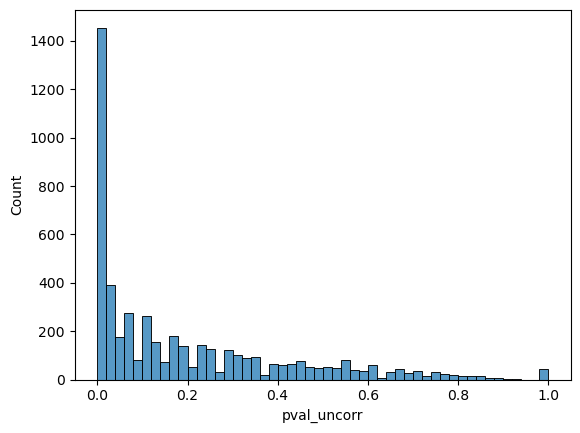

In [24]:
sns.histplot(GO_enrichments[GO_enrichments['e/p'] == 'e']['pval_uncorr'], bins=50)

P-value distribution for enriched GO term looks fine. We can go on to filter according to multiple testing p value correction.

In [221]:
GO_enrichments = GO_enrichments[GO_enrichments['e/p'] == 'e']
GO_enrichments = GO_enrichments[GO_enrichments['Benjamimi/Hochberg'] < 0.01]

In [222]:
GO_enrichments[['term_id', 'Benjamimi/Hochberg']].to_csv('../data/GO_analysis/GO_enrichments/secretomics/predicted_signal_peptides.csv', index=False, header=False, sep='\t')

Here, we can see that the predicted proteins with signal peptides indeed are enriched in proteins of the extracellular regiion (secretion), ER, cell surface, vacuoles, lysosomes, etc. Therefore we can use this list to check if we find enrichment of proteins in the experimental setup with predicted signal peptides

In [15]:
predicted_signal_peptides = pd.read_csv('../data/GO_analysis/Go_targets/secreted_proteins_signalP_0.9.list', header=None, sep='\t')

In [26]:
secretion_up_qupm2 = pd.read_csv('../data/GO_analysis/Go_targets/secret_tryptic_qupm_2_up.list', header=None, sep='\t')

In [27]:
unique_genes = pd.read_csv('../data/GO_analysis/GO_background/full_unique_gene_names.list', header=None, sep='\t')

In [28]:
len_unique_genes = len(set(unique_genes[0]))
len_predicted_signal_peptides_all = len(set(predicted_signal_peptides[0]))
len_secretion_up_qupm2 = len(set(secretion_up_qupm2[0]))
len_predicted_signal_peptides_secretion_up_qupm2 = len(set(secretion_up_qupm2[0]).intersection(set(predicted_signal_peptides[0])))

I will use the Hypergeometric test:

In [32]:
pval = hypergeom.sf(len_predicted_signal_peptides_secretion_up_qupm2-1, len_unique_genes, len_predicted_signal_peptides_all, len_secretion_up_qupm2)

In [33]:
pval

3.9880956276756705e-09

We can see that the number of protein that are secreted and have a predicted signal sequence is significantly higher than random. 

In [34]:
(len_predicted_signal_peptides_secretion_up_qupm2/len_secretion_up_qupm2)/(len_predicted_signal_peptides_all/len_unique_genes)

13.701007838745802

We have an enrichment of 13.7-fold. Of 18 proteins found significantly upregualted in the supernatant after mechnaical perturbation, 9 (50 %) have a predicted signal peptide. Only 3.6 % of all proteins are predicted to have a signal peptide. 

Is there any GO enrichment in ALL qupm > 1 detected proteins in the supernatant?

### 1.1.2 GO Enrichment of all proteins in medium (qupm > 1)

In [50]:
fin_study = '../data/GO_analysis/Go_targets/secret_tryptic_qupm_2.list'         # Study genes
fin_pop   = '../data/GO_analysis/GO_background/full_unique_gene_names.list'  # Population genes
fin_obo   = '../data/GO_analysis/go-basic.obo'             # DAG containing HPO terms
fin_anno  = '../data/GO_analysis/GO_mapping/gene_to_GO.list' # Annotation of genes-to-HPO terms

In [51]:
from goatools.utils import read_geneset

study_ids = read_geneset(fin_study)
population_ids = read_geneset(fin_pop)

      148 READ: ../data/GO_analysis/Go_targets/secret_tryptic_qupm_2.list
   24,470 READ: ../data/GO_analysis/GO_background/full_unique_gene_names.list


In [52]:
from goatools.obo_parser import GODag

godag = GODag(fin_obo)

../data/GO_analysis/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms


In [ ]:
from goatools.anno.idtogos_reader import IdToGosReader

annoobj = IdToGosReader(fin_anno, godag=godag)

id2gos = annoobj.get_id2gos()

In [56]:
from goatools.go_enrichment import GOEnrichmentStudy

goeaobj = GOEnrichmentStudy(
    population_ids,
    annoobj.get_id2gos(),
    godag,
    methods=['bonferroni', 'fdr_bh'],
    pvalcalc='fisher_scipy_stats')

9721 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 40%  9,721 of 24,470 population items found in association


In [57]:
results = goeaobj.run_study_nts(study_ids)


Runing  Ontology Analysis: current study set of 148 IDs.
 76%    111 of    146 study items found in association
 99%    146 of    148 study items found in population(24470)
Calculating 19,581 uncorrected p-values using fisher_scipy_stats
  19,581 terms are associated with  9,721 of 24,470 population items
   3,986 terms are associated with    111 of    148 study items
  METHOD bonferroni:
     206 GO terms found significant (< 0.05=alpha) (206 enriched +   0 purified): local bonferroni
     111 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
  METHOD fdr_bh:
     643 GO terms found significant (< 0.05=alpha) (643 enriched +   0 purified): statsmodels fdr_bh
     111 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [72]:
columns = ['namespace', 'term_id', 'name', 'e/p', 'pval_uncorr', 'Benjamimi/Hochberg', 'Bonferroni', 'study_ratio', 'population_ratio', 'study_items']
GO_enrichments = pd.DataFrame(columns = columns)
length = len(results)
for column in columns:
        GO_enrichments[column] = [''] * length
for i, ntd in enumerate(sorted(results, key=lambda nt: [nt.p_uncorrected, nt.GO])):
    GO_enrichments['namespace'][i] = ntd.NS
    GO_enrichments['term_id'][i] = ntd.GO
    GO_enrichments['name'][i] = ntd.name
    GO_enrichments['e/p'][i] = ntd.enrichment
    GO_enrichments['study_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_study)
    GO_enrichments['population_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_pop)
    GO_enrichments['pval_uncorr'][i] = ntd.p_uncorrected
    GO_enrichments['Bonferroni'][i] = ntd.p_bonferroni
    GO_enrichments['Benjamimi/Hochberg'][i] = ntd.p_fdr_bh
    GO_enrichments['study_items'][i] = ntd.study_items

In [73]:
GO_enrichments = GO_enrichments[GO_enrichments['e/p'] == 'e']
GO_enrichments = GO_enrichments[GO_enrichments['Benjamimi/Hochberg'] < 0.01]

In [74]:
GO_enrichments['fold_enrichment'] = len(GO_enrichments) * ['']
for index, row in GO_enrichments.iterrows():
    study_ratio_true = int(row['study_ratio'].split('/')[0])
    study_ratio_all = int(row['study_ratio'].split('/')[1])
    population_ratio_true = int(row['population_ratio'].split('/')[0])
    population_ratio_all = int(row['population_ratio'].split('/')[1])
    study_ratio = study_ratio_true/study_ratio_all
    population_ratio = population_ratio_true/population_ratio_all
    fold_enrichment = study_ratio/population_ratio
    row['fold_enrichment'] = fold_enrichment
GO_enrichments['pvalue_FDR_log10'] = -1 * GO_enrichments['Benjamimi/Hochberg'].apply(lambda x: np.log10(x) if x > 0 else 0)

I only want to plot GO terms which have at least 3 proteins in the secretet group.Otherwise this will give totally inflated fold changes without much biological meaning.

In [84]:
GO_enrichments_plotting = GO_enrichments[~GO_enrichments['study_ratio'].str.contains('2/')]

In [85]:
GO_enrichments_MF = GO_enrichments_plotting[GO_enrichments_plotting['namespace'] == 'MF']
GO_enrichments_BP = GO_enrichments_plotting[GO_enrichments_plotting['namespace'] == 'BP']
GO_enrichments_CC = GO_enrichments_plotting[GO_enrichments_plotting['namespace'] == 'CC']

In [86]:
GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_CC.sort_values(by='fold_enrichment', ascending=False, inplace=True)

/tmp/ipykernel_101/471193825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_101/471193825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_101/471193825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_CC.sort_values(

In [87]:
GO_enrichments_CC.sort_values(by='fold_enrichment', ascending=False, inplace=True)

norm = colors_mat.Normalize(vmin=GO_enrichments_CC['pvalue_FDR_log10'].min(), vmax=GO_enrichments_CC['pvalue_FDR_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")

colors = cmap.to_rgba(GO_enrichments_CC['pvalue_FDR_log10'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data = GO_enrichments_CC, y = GO_enrichments_CC['name'], x=GO_enrichments_CC['fold_enrichment'], palette=colors)

ax.set_xlabel('Fold enrichment', fontsize=13)
ax.set_ylabel('GO terms - Cellular Component', fontsize=15)

fig.colorbar(cmap)

/tmp/ipykernel_101/3261329147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_CC.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_101/3261329147.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


In [88]:
GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)

norm = colors_mat.Normalize(vmin=GO_enrichments_MF['pvalue_FDR_log10'].min(), vmax=GO_enrichments_MF['pvalue_FDR_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")

colors = cmap.to_rgba(GO_enrichments_MF['pvalue_FDR_log10'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data = GO_enrichments_MF, y = GO_enrichments_MF['name'], x=GO_enrichments_MF['fold_enrichment'], palette=colors)

ax.set_xlabel('Fold enrichment', fontsize=13)
ax.set_ylabel('GO terms - Molecular Function', fontsize=15)

fig.colorbar(cmap)

/tmp/ipykernel_101/3803633753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_101/3803633753.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


In [93]:
GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)

norm = colors_mat.Normalize(vmin=GO_enrichments_BP['pvalue_FDR_log10'].min(), vmax=GO_enrichments_BP['pvalue_FDR_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")

colors = cmap.to_rgba(GO_enrichments_BP['pvalue_FDR_log10'])

fig, ax = plt.subplots(figsize=(8, 30))
sns.barplot(data = GO_enrichments_BP, y = GO_enrichments_BP['name'], x=GO_enrichments_BP['fold_enrichment'], palette=colors)

ax.set_xlabel('Fold enrichment', fontsize=13)
ax.set_ylabel('GO terms - Biological Process', fontsize=15)

fig.colorbar(cmap)

/tmp/ipykernel_101/1379172424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_101/1379172424.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


For the secretomics experiment we chose to use the full sponge transcriptome as the background for GO enrichment. For that, we are using unique merged gene names.
For all proteins up- or downregulated, the statistical power is low (only 10-20 proteins up- or downregulated), however we looked for enrichment of all upregualted proteins that have been detected in the supernatant (using all proteins as a background) and a very low uncorrected pvalue as a cut-off:

### 1.1.3 GO Enrichment of proteins uregulated in secretion with qupm > 2

In [3]:
fin_study = '../data/GO_analysis/Go_targets/secret_tryptic_qupm_2_up.list'         # Study genes
fin_pop   = '../data/GO_analysis/GO_background/full_unique_gene_names.list'  # Population genes
fin_obo   = '../data/GO_analysis/go-basic.obo'             # DAG containing HPO terms
fin_anno  = '../data/GO_analysis/GO_mapping/gene_to_GO.list' # Annotation of genes-to-HPO terms

In [4]:
from goatools.utils import read_geneset

study_ids = read_geneset(fin_study)
population_ids = read_geneset(fin_pop)

       18 READ: ../data/GO_analysis/Go_targets/secret_tryptic_qupm_2_up.list
   24,470 READ: ../data/GO_analysis/GO_background/full_unique_gene_names.list


In [5]:
from goatools.obo_parser import GODag

godag = GODag(fin_obo)

../data/GO_analysis/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms


In [ ]:
from goatools.anno.idtogos_reader import IdToGosReader

annoobj = IdToGosReader(fin_anno, godag=godag)

id2gos = annoobj.get_id2gos()

In [7]:
from goatools.go_enrichment import GOEnrichmentStudy

goeaobj = GOEnrichmentStudy(
    population_ids,
    annoobj.get_id2gos(),
    godag,
    methods=['bonferroni', 'fdr_bh'],
    pvalcalc='fisher_scipy_stats')

9721 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 40%  9,721 of 24,470 population items found in association


In [8]:
results = goeaobj.run_study_nts(study_ids)


Runing  Ontology Analysis: current study set of 18 IDs.
 67%     12 of     18 study items found in association
100%     18 of     18 study items found in population(24470)
Calculating 19,581 uncorrected p-values using fisher_scipy_stats
  19,581 terms are associated with  9,721 of 24,470 population items
   1,702 terms are associated with     12 of     18 study items
  METHOD bonferroni:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local bonferroni
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [9]:
columns = ['namespace', 'term_id', 'e/p', 'pval_uncorr', 'Benjamimi/Hochberg', 'Bonferroni', 'study_ratio', 'population_ratio']
GO_enrichments = pd.DataFrame(columns = columns)
length = len(results)
for column in columns:
        GO_enrichments[column] = [''] * length
for i, ntd in enumerate(sorted(results, key=lambda nt: [nt.p_uncorrected, nt.GO])):
    GO_enrichments['namespace'][i] = ntd.NS
    GO_enrichments['term_id'][i] = ntd.GO
    GO_enrichments['e/p'][i] = ntd.enrichment
    GO_enrichments['study_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_study)
    GO_enrichments['population_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_pop)
    GO_enrichments['pval_uncorr'][i] = ntd.p_uncorrected
    GO_enrichments['Bonferroni'][i] = ntd.p_bonferroni
    GO_enrichments['Benjamimi/Hochberg'][i] = ntd.p_fdr_bh

In [122]:
GO_enrichments = GO_enrichments[GO_enrichments['e/p'] == 'e']
GO_enrichments = GO_enrichments[GO_enrichments['pval_uncorr'] < 0.001]

In [125]:
GO_enrichments[['term_id', 'pval_uncorr']].to_csv('../data/GO_analysis/GO_enrichments/secretomics/secret_tryptic_qupm_2_up.csv', index=False, header=False, sep='\t')

### 1.2 GO Enrichment of Phosphoproteomics results

Specifically for Phosphoproteomics, I will not differentiate between up- or downregulation of phosphorylation. Both types can influence the proteins function. I will differentiate between mechanically and NO treated sponges. As background, I always use ALL proteins detected in the specific MS run.

#### 1.2.1 Phosphoproteomics - mechanical treatment, all significantly regulated proteins

In [6]:
fin_study = '../data/GO_analysis/Go_targets/phospho_mech_sig.list'         # Study genes
fin_pop   = '../data/GO_analysis/GO_background/phospho_mech_BG.list'  # Population genes
fin_obo   = '../data/GO_analysis/go-basic.obo'             # DAG containing HPO terms
fin_anno  = '../data/GO_analysis/GO_mapping/gene_to_GO.list' # Annotation of genes-to-HPO terms

In [7]:
from goatools.utils import read_geneset

study_ids = read_geneset(fin_study)
population_ids = read_geneset(fin_pop)

      223 READ: ../data/GO_analysis/Go_targets/phospho_mech_sig.list
    3,567 READ: ../data/GO_analysis/GO_background/phospho_mech_BG.list


In [8]:
from goatools.obo_parser import GODag

godag = GODag(fin_obo)

../data/GO_analysis/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms


In [ ]:
from goatools.anno.idtogos_reader import IdToGosReader

annoobj = IdToGosReader(fin_anno, godag=godag)

id2gos = annoobj.get_id2gos()

In [10]:
from goatools.go_enrichment import GOEnrichmentStudy

goeaobj = GOEnrichmentStudy(
    population_ids,
    annoobj.get_id2gos(),
    godag,
    methods=['bonferroni', 'fdr_bh'],
    pvalcalc='fisher_scipy_stats')

9721 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 67%  2,386 of  3,567 population items found in association


In [11]:
results = goeaobj.run_study_nts(study_ids)


Runing  Ontology Analysis: current study set of 223 IDs.
 74%    161 of    219 study items found in association
 98%    219 of    223 study items found in population(3567)
Calculating 14,767 uncorrected p-values using fisher_scipy_stats
  14,767 terms are associated with  2,386 of  3,567 population items
   5,746 terms are associated with    161 of    223 study items
  METHOD bonferroni:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local bonferroni
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      75 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [12]:
columns = ['namespace', 'term_id', 'name', 'e/p', 'pval_uncorr', 'Benjamimi/Hochberg', 'Bonferroni', 'study_ratio', 'population_ratio', 'study_items']
GO_enrichments = pd.DataFrame(columns = columns)
length = len(results)
for column in columns:
        GO_enrichments[column] = [''] * length
for i, ntd in enumerate(sorted(results, key=lambda nt: [nt.p_uncorrected, nt.GO])):
    GO_enrichments['namespace'][i] = ntd.NS
    GO_enrichments['term_id'][i] = ntd.GO
    GO_enrichments['name'][i] = ntd.name
    GO_enrichments['e/p'][i] = ntd.enrichment
    GO_enrichments['study_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_study)
    GO_enrichments['population_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_pop)
    GO_enrichments['pval_uncorr'][i] = ntd.p_uncorrected
    GO_enrichments['Bonferroni'][i] = ntd.p_bonferroni
    GO_enrichments['Benjamimi/Hochberg'][i] = ntd.p_fdr_bh
    GO_enrichments['study_items'][i] = ntd.study_items

In [13]:
GO_enrichments = GO_enrichments[GO_enrichments['e/p'] == 'e']
GO_enrichments = GO_enrichments[GO_enrichments['pval_uncorr'] < 0.001]

**Notice the uncorrected p-value cut-off of 0.001!!!**

In [14]:
GO_enrichments['fold_enrichment'] = len(GO_enrichments) * ['']
for index, row in GO_enrichments.iterrows():
    study_ratio_true = int(row['study_ratio'].split('/')[0])
    study_ratio_all = int(row['study_ratio'].split('/')[1])
    population_ratio_true = int(row['population_ratio'].split('/')[0])
    population_ratio_all = int(row['population_ratio'].split('/')[1])
    study_ratio = study_ratio_true/study_ratio_all
    population_ratio = population_ratio_true/population_ratio_all
    fold_enrichment = study_ratio/population_ratio
    row['fold_enrichment'] = fold_enrichment
GO_enrichments['pvalue_uncorr_log10'] = -1 * GO_enrichments['pval_uncorr'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [15]:
GO_enrichments_MF = GO_enrichments[GO_enrichments['namespace'] == 'MF']
GO_enrichments_BP = GO_enrichments[GO_enrichments['namespace'] == 'BP']
GO_enrichments_CC = GO_enrichments[GO_enrichments['namespace'] == 'CC']

In [16]:
GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_CC.sort_values(by='fold_enrichment', ascending=False, inplace=True)

/tmp/ipykernel_63/471193825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_63/471193825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_63/471193825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_CC.sort_values(by=

In [326]:
norm = colors_mat.Normalize(vmin=GO_enrichments['pvalue_uncorr_log10'].min(), vmax=GO_enrichments['pvalue_uncorr_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")

colors_MF = cmap.to_rgba(GO_enrichments_MF['pvalue_uncorr_log10'])
colors_BP = cmap.to_rgba(GO_enrichments_BP['pvalue_uncorr_log10'])
colors_CC = cmap.to_rgba(GO_enrichments_CC['pvalue_uncorr_log10'])


fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [10, 50, 10], 'hspace':0.05})

sns.barplot(GO_enrichments_MF, y = GO_enrichments_MF['name'], x=GO_enrichments_MF['fold_enrichment'], palette=colors_MF, ax=axs[0])
sns.barplot(GO_enrichments_BP, y = GO_enrichments_BP['name'], x=GO_enrichments_BP['fold_enrichment'], palette=colors_BP, ax=axs[1])
sns.barplot(GO_enrichments_CC, y = GO_enrichments_CC['name'], x=GO_enrichments_CC['fold_enrichment'], palette=colors_CC, ax=axs[2])

axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[0].set_xlabel('')
axs[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[1].set_xlabel('')

axs[0].set_ylabel('Molecular Function', rotation=90, labelpad=40, fontweight='bold')
axs[0].yaxis.set_label_coords(-0.7, 0.5)
axs[1].set_ylabel('Biological Process', rotation=90, labelpad=40, fontweight='bold')
axs[1].yaxis.set_label_coords(-0.7, 0.5)
axs[2].set_ylabel('Cellular Component', rotation=90, labelpad=40, fontweight='bold')
axs[2].yaxis.set_label_coords(-0.7, 0.5)

cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
fig.colorbar(cmap, cax=cbar_ax)

In [22]:
GO_enrichments[['term_id', 'pval_uncorr']].to_csv('../data/GO_analysis/GO_enrichments/Phospho/mechanical.csv', index=False, header=False, sep='\t')

#### 1.2.1 Phosphoproteomics - NO treatment

In [214]:
fin_study = '../data/GO_analysis/Go_targets/phospho_no_sig.list'         # Study genes
fin_pop   = '../data/GO_analysis/GO_background/phospho_no_BG.list'  # Population genes
fin_obo   = '../data/GO_analysis/go-basic.obo'             # DAG containing HPO terms
fin_anno  = '../data/GO_analysis/GO_mapping/gene_to_GO.list' # Annotation of genes-to-HPO terms

In [215]:
from goatools.utils import read_geneset

study_ids = read_geneset(fin_study)
population_ids = read_geneset(fin_pop)

      266 READ: ../data/GO_analysis/Go_targets/phospho_no_sig.list
    3,567 READ: ../data/GO_analysis/GO_background/phospho_no_BG.list


In [216]:
from goatools.obo_parser import GODag

godag = GODag(fin_obo)

../data/GO_analysis/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms


In [ ]:
from goatools.anno.idtogos_reader import IdToGosReader

annoobj = IdToGosReader(fin_anno, godag=godag)

id2gos = annoobj.get_id2gos()

In [218]:
from goatools.go_enrichment import GOEnrichmentStudy

goeaobj = GOEnrichmentStudy(
    population_ids,
    annoobj.get_id2gos(),
    godag,
    methods=['bonferroni', 'fdr_bh'],
    pvalcalc='fisher_scipy_stats')

9721 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 67%  2,386 of  3,567 population items found in association


In [219]:
results = goeaobj.run_study_nts(study_ids)


Runing  Ontology Analysis: current study set of 266 IDs.
 70%    178 of    253 study items found in association
 95%    253 of    266 study items found in population(3567)
Calculating 14,767 uncorrected p-values using fisher_scipy_stats
  14,767 terms are associated with  2,386 of  3,567 population items
   6,103 terms are associated with    178 of    266 study items
  METHOD bonferroni:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local bonferroni
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
  METHOD fdr_bh:
      43 GO terms found significant (< 0.05=alpha) ( 43 enriched +   0 purified): statsmodels fdr_bh
     149 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [220]:
columns = ['namespace', 'term_id', 'name', 'e/p', 'pval_uncorr', 'Benjamimi/Hochberg', 'Bonferroni', 'study_ratio', 'population_ratio', 'study_items']
GO_enrichments = pd.DataFrame(columns = columns)
length = len(results)
for column in columns:
        GO_enrichments[column] = [''] * length
for i, ntd in enumerate(sorted(results, key=lambda nt: [nt.p_uncorrected, nt.GO])):
    GO_enrichments['namespace'][i] = ntd.NS
    GO_enrichments['term_id'][i] = ntd.GO
    GO_enrichments['name'][i] = ntd.name
    GO_enrichments['e/p'][i] = ntd.enrichment
    GO_enrichments['study_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_study)
    GO_enrichments['population_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_pop)
    GO_enrichments['pval_uncorr'][i] = ntd.p_uncorrected
    GO_enrichments['Bonferroni'][i] = ntd.p_bonferroni
    GO_enrichments['Benjamimi/Hochberg'][i] = ntd.p_fdr_bh
    GO_enrichments['study_items'][i] = ntd.study_items

In [221]:
GO_enrichments = GO_enrichments[GO_enrichments['e/p'] == 'e']
GO_enrichments = GO_enrichments[GO_enrichments['pval_uncorr'] < 0.001]

**Notice the uncorrected p-value cut-off of 0.001!!!**

In [222]:
GO_enrichments['fold_enrichment'] = len(GO_enrichments) * ['']
for index, row in GO_enrichments.iterrows():
    study_ratio_true = int(row['study_ratio'].split('/')[0])
    study_ratio_all = int(row['study_ratio'].split('/')[1])
    population_ratio_true = int(row['population_ratio'].split('/')[0])
    population_ratio_all = int(row['population_ratio'].split('/')[1])
    study_ratio = study_ratio_true/study_ratio_all
    population_ratio = population_ratio_true/population_ratio_all
    fold_enrichment = study_ratio/population_ratio
    row['fold_enrichment'] = fold_enrichment
GO_enrichments['pvalue_uncorr_log10'] = -1 * GO_enrichments['pval_uncorr'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [223]:
GO_enrichments_MF = GO_enrichments[GO_enrichments['namespace'] == 'MF']
GO_enrichments_BP = GO_enrichments[GO_enrichments['namespace'] == 'BP']
GO_enrichments_CC = GO_enrichments[GO_enrichments['namespace'] == 'CC']

In [224]:
GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_CC.sort_values(by='fold_enrichment', ascending=False, inplace=True)

/tmp/ipykernel_65/471193825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_65/471193825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_65/471193825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_CC.sort_values(by=

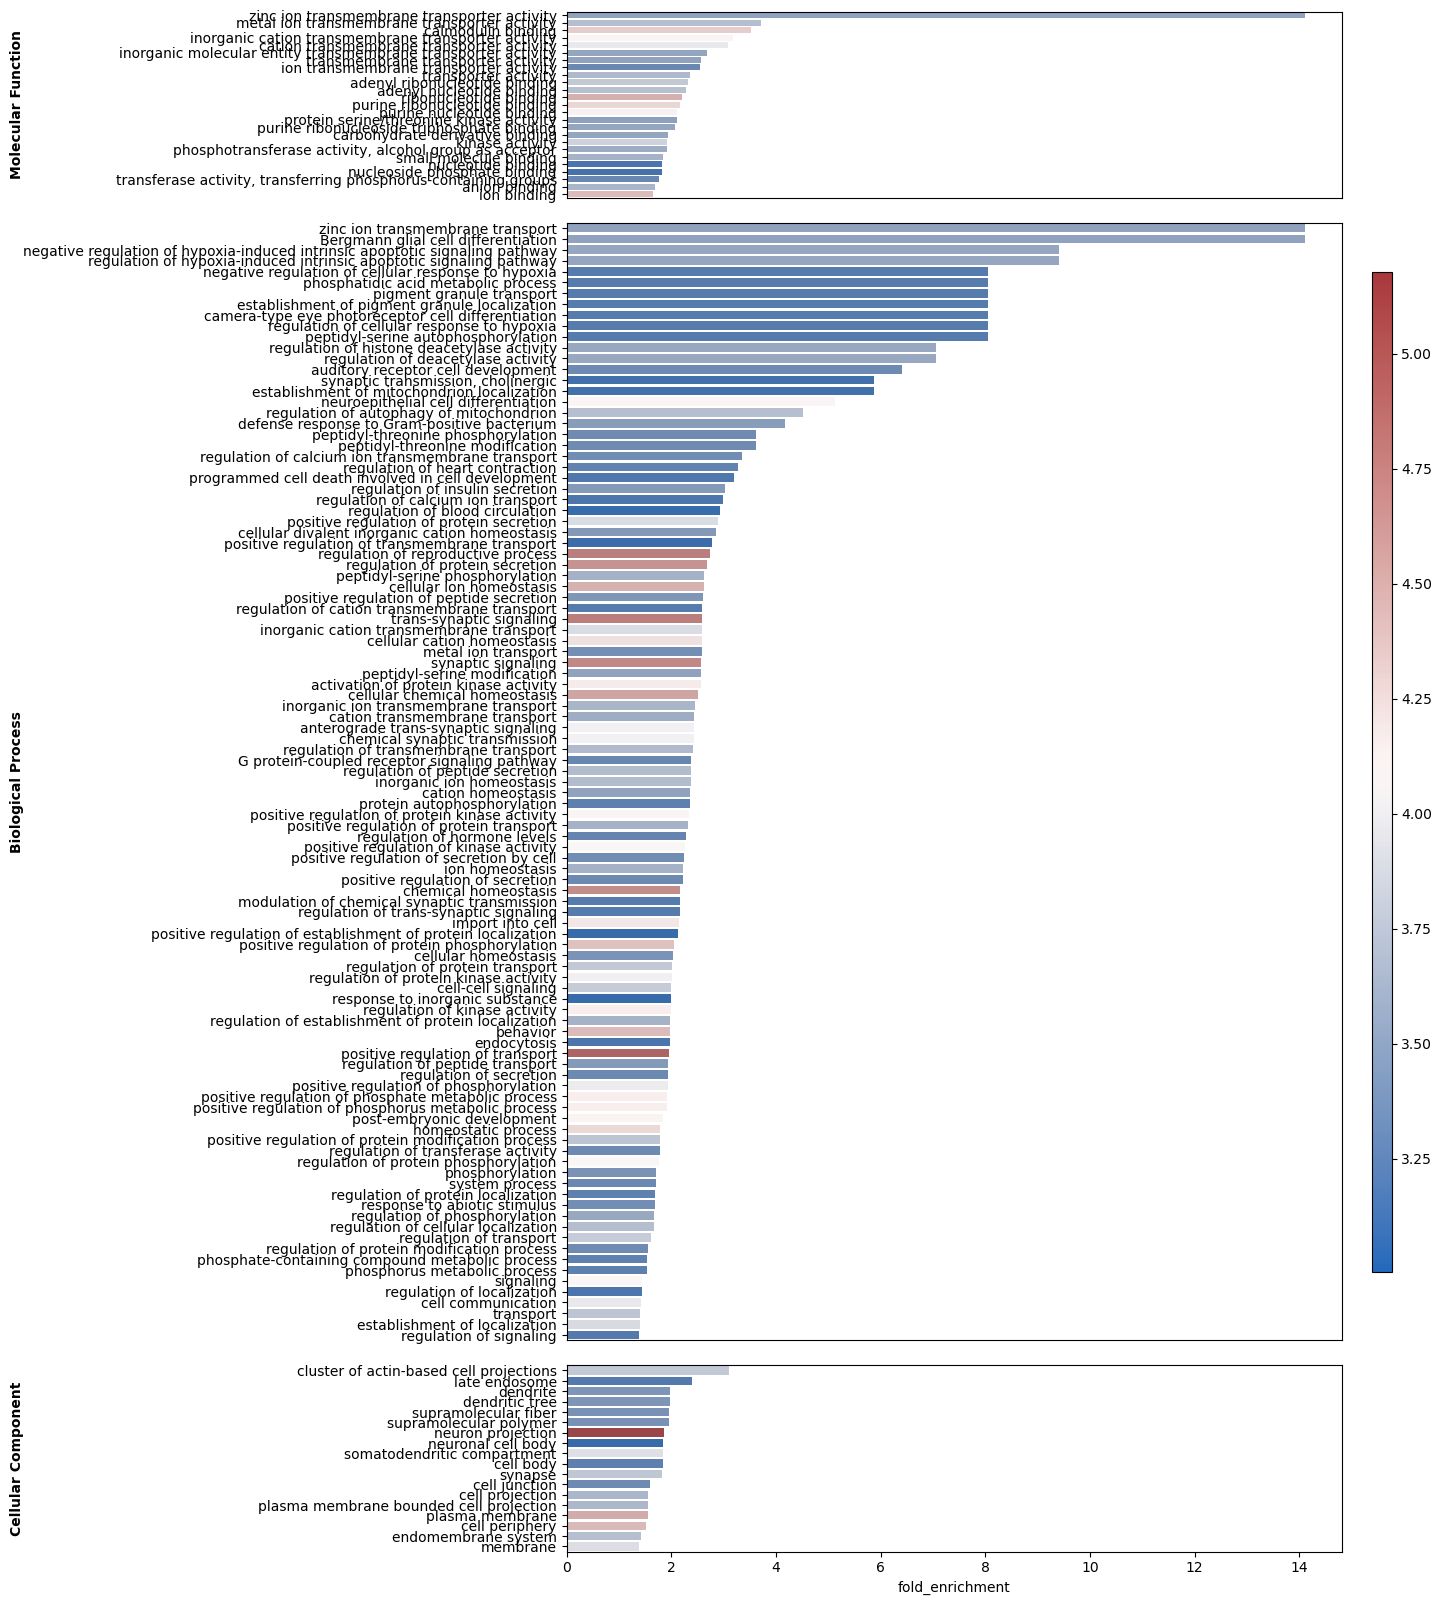

In [229]:
norm = colors_mat.Normalize(vmin=GO_enrichments['pvalue_uncorr_log10'].min(), vmax=GO_enrichments['pvalue_uncorr_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")

colors_MF = cmap.to_rgba(GO_enrichments_MF['pvalue_uncorr_log10'])
colors_BP = cmap.to_rgba(GO_enrichments_BP['pvalue_uncorr_log10'])
colors_CC = cmap.to_rgba(GO_enrichments_CC['pvalue_uncorr_log10'])


fig, axs = plt.subplots(3, 1, figsize=(10, 20), sharex=True, gridspec_kw={'height_ratios': [10, 60, 10], 'hspace':0.05})

sns.barplot(GO_enrichments_MF, y = GO_enrichments_MF['name'], x=GO_enrichments_MF['fold_enrichment'], palette=colors_MF, ax=axs[0])
sns.barplot(GO_enrichments_BP, y = GO_enrichments_BP['name'], x=GO_enrichments_BP['fold_enrichment'], palette=colors_BP, ax=axs[1])
sns.barplot(GO_enrichments_CC, y = GO_enrichments_CC['name'], x=GO_enrichments_CC['fold_enrichment'], palette=colors_CC, ax=axs[2])

axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[0].set_xlabel('')
axs[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[1].set_xlabel('')

axs[0].set_ylabel('Molecular Function', rotation=90, labelpad=40, fontweight='bold')
axs[0].yaxis.set_label_coords(-0.7, 0.5)
axs[1].set_ylabel('Biological Process', rotation=90, labelpad=40, fontweight='bold')
axs[1].yaxis.set_label_coords(-0.7, 0.5)
axs[2].set_ylabel('Cellular Component', rotation=90, labelpad=40, fontweight='bold')
axs[2].yaxis.set_label_coords(-0.7, 0.5)

cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
fig.colorbar(cmap, cax=cbar_ax)

In [226]:
GO_enrichments[['term_id', 'pval_uncorr']].to_csv('../data/GO_analysis/GO_enrichments/Phospho/NO_treatment.csv', index=False, header=False, sep='\t')

### 1.2 GO Enrichment of TPP results

#### 1.2.1 TPP - mechanical treatment

In [15]:
fin_study = '../data/GO_analysis/Go_targets/TPP_mech_sig.list'         # Study genes
fin_pop   = '../data/GO_analysis/GO_background/TPP_mech_BG.list'  # Population genes
fin_obo   = '../data/GO_analysis/go-basic.obo'             # DAG containing HPO terms
fin_anno  = '../data/GO_analysis/GO_mapping/gene_to_GO.list' # Annotation of genes-to-HPO terms

In [16]:
from goatools.utils import read_geneset

study_ids = read_geneset(fin_study)
population_ids = read_geneset(fin_pop)

       51 READ: ../data/GO_analysis/Go_targets/TPP_mech_sig.list
    3,331 READ: ../data/GO_analysis/GO_background/TPP_mech_BG.list


In [17]:
from goatools.obo_parser import GODag

godag = GODag(fin_obo)

../data/GO_analysis/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms


In [ ]:
from goatools.anno.idtogos_reader import IdToGosReader

annoobj = IdToGosReader(fin_anno, godag=godag)

id2gos = annoobj.get_id2gos()

In [21]:
from goatools.go_enrichment import GOEnrichmentStudy

goeaobj = GOEnrichmentStudy(
    population_ids,
    annoobj.get_id2gos(),
    godag,
    methods=['bonferroni', 'fdr_bh'],
    pvalcalc='fisher_scipy_stats')

9721 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 76%  2,531 of  3,331 population items found in association


In [22]:
results = goeaobj.run_study_nts(study_ids)


Runing  Ontology Analysis: current study set of 51 IDs.
 76%     39 of     51 study items found in association
100%     51 of     51 study items found in population(3331)
Calculating 15,021 uncorrected p-values using fisher_scipy_stats
  15,021 terms are associated with  2,531 of  3,331 population items
   1,994 terms are associated with     39 of     51 study items
  METHOD bonferroni:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local bonferroni
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [23]:
columns = ['namespace', 'term_id', 'name', 'e/p', 'pval_uncorr', 'Benjamimi/Hochberg', 'Bonferroni', 'study_ratio', 'population_ratio', 'study_items']
GO_enrichments = pd.DataFrame(columns = columns)
length = len(results)
for column in columns:
        GO_enrichments[column] = [''] * length
for i, ntd in enumerate(sorted(results, key=lambda nt: [nt.p_uncorrected, nt.GO])):
    GO_enrichments['namespace'][i] = ntd.NS
    GO_enrichments['term_id'][i] = ntd.GO
    GO_enrichments['name'][i] = ntd.name
    GO_enrichments['e/p'][i] = ntd.enrichment
    GO_enrichments['study_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_study)
    GO_enrichments['population_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_pop)
    GO_enrichments['pval_uncorr'][i] = ntd.p_uncorrected
    GO_enrichments['Bonferroni'][i] = ntd.p_bonferroni
    GO_enrichments['Benjamimi/Hochberg'][i] = ntd.p_fdr_bh
    GO_enrichments['study_items'][i] = ntd.study_items

In [25]:
GO_enrichments = GO_enrichments[GO_enrichments['e/p'] == 'e']
GO_enrichments = GO_enrichments[GO_enrichments['pval_uncorr'] < 0.005]

**Notice the uncorrected p-value cut-off of 0.005!!!**

In [26]:
GO_enrichments['fold_enrichment'] = len(GO_enrichments) * ['']
for index, row in GO_enrichments.iterrows():
    study_ratio_true = int(row['study_ratio'].split('/')[0])
    study_ratio_all = int(row['study_ratio'].split('/')[1])
    population_ratio_true = int(row['population_ratio'].split('/')[0])
    population_ratio_all = int(row['population_ratio'].split('/')[1])
    study_ratio = study_ratio_true/study_ratio_all
    population_ratio = population_ratio_true/population_ratio_all
    fold_enrichment = study_ratio/population_ratio
    row['fold_enrichment'] = fold_enrichment
GO_enrichments['pvalue_uncorr_log10'] = -1 * GO_enrichments['pval_uncorr'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [27]:
GO_enrichments_MF = GO_enrichments[GO_enrichments['namespace'] == 'MF']
GO_enrichments_BP = GO_enrichments[GO_enrichments['namespace'] == 'BP']
GO_enrichments_CC = GO_enrichments[GO_enrichments['namespace'] == 'CC']

In [28]:
GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_CC.sort_values(by='fold_enrichment', ascending=False, inplace=True)

/tmp/ipykernel_180/471193825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_180/471193825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_180/471193825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_CC.sort_values(

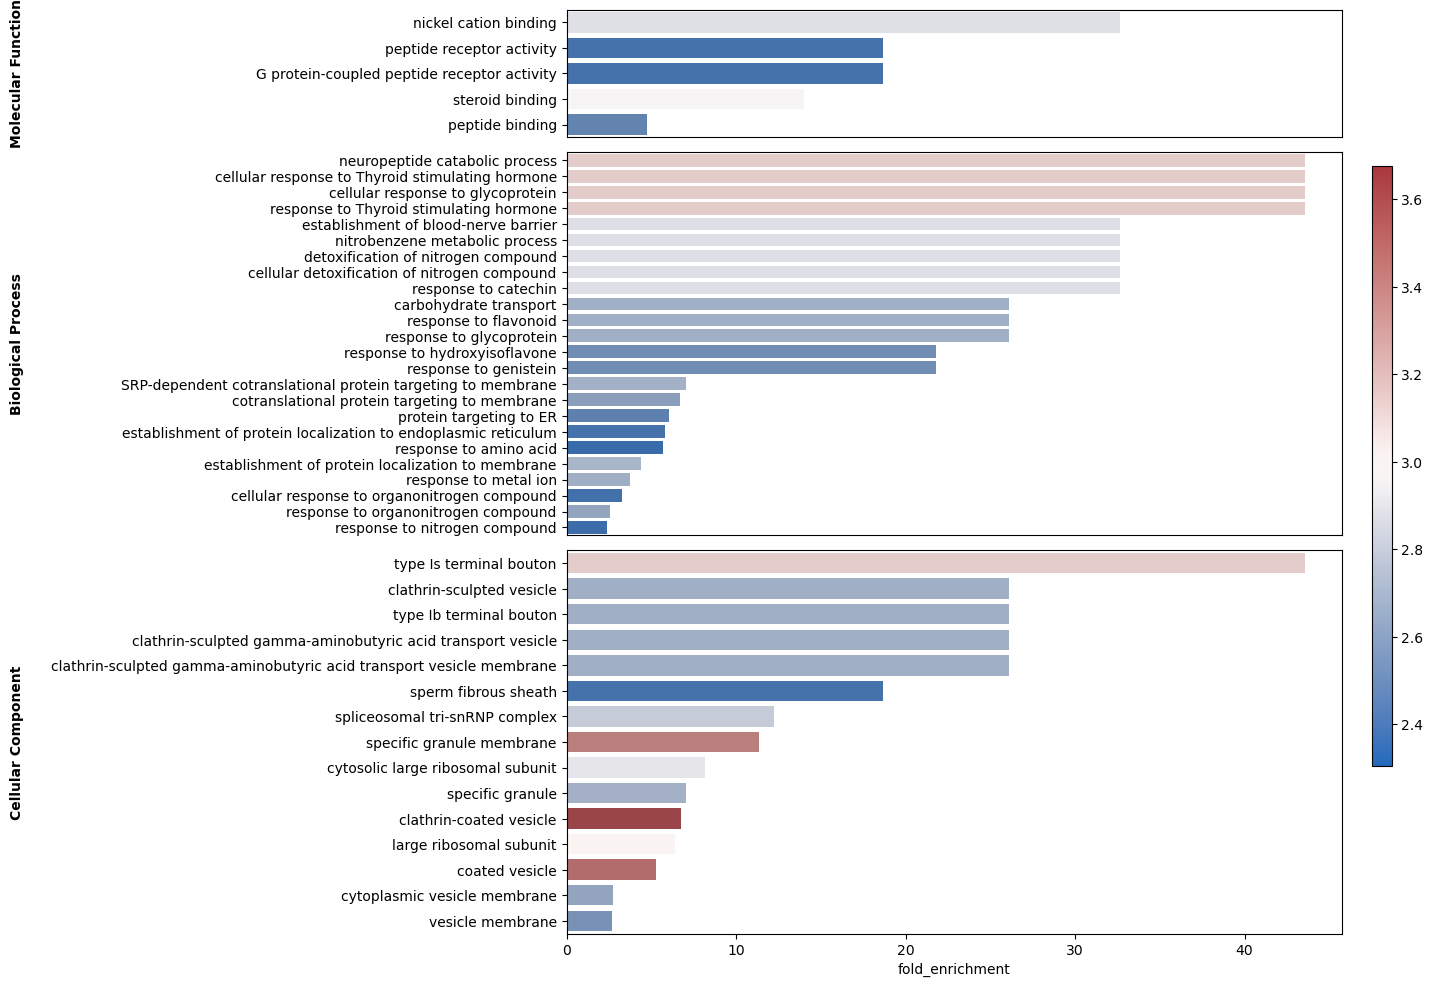

In [29]:
norm = colors_mat.Normalize(vmin=GO_enrichments['pvalue_uncorr_log10'].min(), vmax=GO_enrichments['pvalue_uncorr_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")

colors_MF = cmap.to_rgba(GO_enrichments_MF['pvalue_uncorr_log10'])
colors_BP = cmap.to_rgba(GO_enrichments_BP['pvalue_uncorr_log10'])
colors_CC = cmap.to_rgba(GO_enrichments_CC['pvalue_uncorr_log10'])


fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [10, 30, 30], 'hspace':0.05})

sns.barplot(data = GO_enrichments_MF, y = GO_enrichments_MF['name'], x=GO_enrichments_MF['fold_enrichment'], palette=colors_MF, ax=axs[0])
sns.barplot(data =GO_enrichments_BP, y = GO_enrichments_BP['name'], x=GO_enrichments_BP['fold_enrichment'], palette=colors_BP, ax=axs[1])
sns.barplot(data =GO_enrichments_CC, y = GO_enrichments_CC['name'], x=GO_enrichments_CC['fold_enrichment'], palette=colors_CC, ax=axs[2])

axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[0].set_xlabel('')
axs[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[1].set_xlabel('')

axs[0].set_ylabel('Molecular Function', rotation=90, labelpad=40, fontweight='bold')
axs[0].yaxis.set_label_coords(-0.7, 0.5)
axs[1].set_ylabel('Biological Process', rotation=90, labelpad=40, fontweight='bold')
axs[1].yaxis.set_label_coords(-0.7, 0.5)
axs[2].set_ylabel('Cellular Component', rotation=90, labelpad=40, fontweight='bold')
axs[2].yaxis.set_label_coords(-0.7, 0.5)

cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
fig.colorbar(cmap, cax=cbar_ax)

Now a plot with all combined. However, in this plot, I excluded all GO terms that were only enriched because based on only 2 genes in the study. This however is getting rid of the neuropeptide processing genes, which is sad.

In [36]:
GO_enrichments.sort_values(by='pvalue_uncorr_log10', ascending=False, inplace=True)

GO_enrichments_plotting = GO_enrichments[~GO_enrichments['study_ratio'].str.contains('2/')]

norm = colors_mat.Normalize(vmin=GO_enrichments['pvalue_uncorr_log10'].min(), vmax=GO_enrichments['pvalue_uncorr_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")

colors = cmap.to_rgba(GO_enrichments_plotting['pvalue_uncorr_log10'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data = GO_enrichments_plotting, y = GO_enrichments_plotting['name'], x=GO_enrichments_plotting['fold_enrichment'], palette=colors)

ax.set_xlabel('Fold enrichment', fontsize=18)
ax.set_ylabel('')

ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=12)

fig.colorbar(cmap).set_label("log10 p-value", fontsize=18)

plt.savefig('../paper/figures/fig4/TPP_mech_GOterm_enrichment.svg')

/tmp/ipykernel_180/4186198831.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap).set_label("log10 p-value", fontsize=18)


In [202]:
GO_enrichments[['term_id', 'pval_uncorr']].to_csv('../data/GO_analysis/GO_enrichments/TPP/mechanical.csv', index=False, header=False, sep='\t')

#### 1.2.1 TPP - Nitric oxide treatment

In [37]:
fin_study = '../data/GO_analysis/Go_targets/TPP_NO_sig.list'         # Study genes
fin_pop   = '../data/GO_analysis/GO_background/TPP_NO_BG.list'  # Population genes
fin_obo   = '../data/GO_analysis/go-basic.obo'             # DAG containing HPO terms
fin_anno  = '../data/GO_analysis/GO_mapping/gene_to_GO.list' # Annotation of genes-to-HPO terms

In [38]:
from goatools.utils import read_geneset

study_ids = read_geneset(fin_study)
population_ids = read_geneset(fin_pop)

      124 READ: ../data/GO_analysis/Go_targets/TPP_NO_sig.list
    5,595 READ: ../data/GO_analysis/GO_background/TPP_NO_BG.list


In [39]:
from goatools.obo_parser import GODag

godag = GODag(fin_obo)

../data/GO_analysis/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms


In [ ]:
from goatools.anno.idtogos_reader import IdToGosReader

annoobj = IdToGosReader(fin_anno, godag=godag)

id2gos = annoobj.get_id2gos()

In [41]:
from goatools.go_enrichment import GOEnrichmentStudy

goeaobj = GOEnrichmentStudy(
    population_ids,
    annoobj.get_id2gos(),
    godag,
    methods=['bonferroni', 'fdr_bh'],
    pvalcalc='fisher_scipy_stats')

9721 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 72%  4,003 of  5,595 population items found in association


In [42]:
results = goeaobj.run_study_nts(study_ids)


Runing  Ontology Analysis: current study set of 124 IDs.
 73%     90 of    124 study items found in association
100%    124 of    124 study items found in population(5595)
Calculating 16,833 uncorrected p-values using fisher_scipy_stats
  16,833 terms are associated with  4,003 of  5,595 population items
   3,986 terms are associated with     90 of    124 study items
  METHOD bonferroni:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): local bonferroni
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [43]:
columns = ['namespace', 'term_id', 'name', 'e/p', 'pval_uncorr', 'Benjamimi/Hochberg', 'Bonferroni', 'study_ratio', 'population_ratio', 'study_items']
GO_enrichments = pd.DataFrame(columns = columns)
length = len(results)
for column in columns:
        GO_enrichments[column] = [''] * length
for i, ntd in enumerate(sorted(results, key=lambda nt: [nt.p_uncorrected, nt.GO])):
    GO_enrichments['namespace'][i] = ntd.NS
    GO_enrichments['term_id'][i] = ntd.GO
    GO_enrichments['name'][i] = ntd.name
    GO_enrichments['e/p'][i] = ntd.enrichment
    GO_enrichments['study_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_study)
    GO_enrichments['population_ratio'][i] = '{}/{}'.format(*ntd.ratio_in_pop)
    GO_enrichments['pval_uncorr'][i] = ntd.p_uncorrected
    GO_enrichments['Bonferroni'][i] = ntd.p_bonferroni
    GO_enrichments['Benjamimi/Hochberg'][i] = ntd.p_fdr_bh
    GO_enrichments['study_items'][i] = ntd.study_items

In [44]:
GO_enrichments = GO_enrichments[GO_enrichments['e/p'] == 'e']
GO_enrichments = GO_enrichments[GO_enrichments['pval_uncorr'] < 0.01]

**Notice the uncorrected p-value cut-off of 0.01!!!**

In [45]:
GO_enrichments[['term_id', 'pval_uncorr']].to_csv('../data/GO_analysis/GO_enrichments/TPP/NO.csv', index=False, header=False, sep='\t')

In [46]:
GO_enrichments['fold_enrichment'] = len(GO_enrichments) * ['']
for index, row in GO_enrichments.iterrows():
    study_ratio_true = int(row['study_ratio'].split('/')[0])
    study_ratio_all = int(row['study_ratio'].split('/')[1])
    population_ratio_true = int(row['population_ratio'].split('/')[0])
    population_ratio_all = int(row['population_ratio'].split('/')[1])
    study_ratio = study_ratio_true/study_ratio_all
    population_ratio = population_ratio_true/population_ratio_all
    fold_enrichment = study_ratio/population_ratio
    row['fold_enrichment'] = fold_enrichment
GO_enrichments['pvalue_uncorr_log10'] = -1 * GO_enrichments['pval_uncorr'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [47]:
GO_enrichments_MF = GO_enrichments[GO_enrichments['namespace'] == 'MF']
GO_enrichments_BP = GO_enrichments[GO_enrichments['namespace'] == 'BP']
GO_enrichments_CC = GO_enrichments[GO_enrichments['namespace'] == 'CC']

In [48]:
GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)

GO_enrichments_CC.sort_values(by='fold_enrichment', ascending=False, inplace=True)

/tmp/ipykernel_180/471193825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_MF.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_180/471193825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_BP.sort_values(by='fold_enrichment', ascending=False, inplace=True)
/tmp/ipykernel_180/471193825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_enrichments_CC.sort_values(

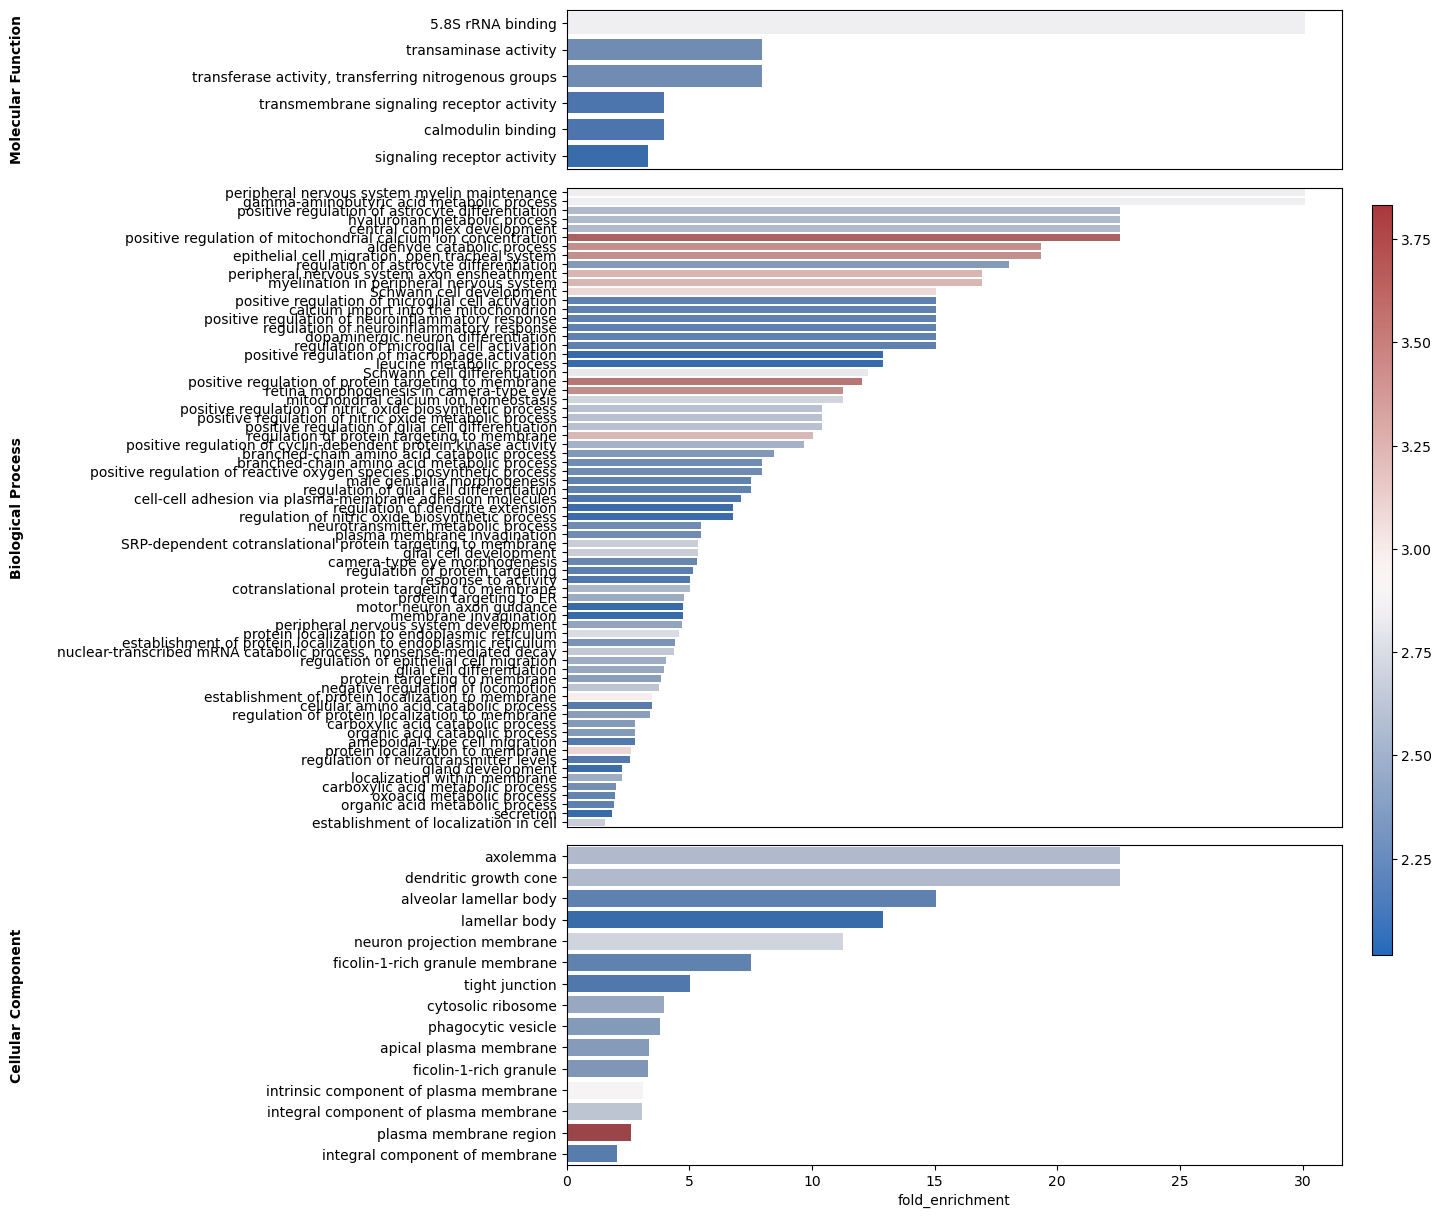

In [51]:
norm = colors_mat.Normalize(vmin=GO_enrichments['pvalue_uncorr_log10'].min(), vmax=GO_enrichments['pvalue_uncorr_log10'].max())

# create a colormap from the normalized values and the "viridis" palette
cmap = cm.ScalarMappable(norm=norm, cmap="vlag")

colors_MF = cmap.to_rgba(GO_enrichments_MF['pvalue_uncorr_log10'])
colors_BP = cmap.to_rgba(GO_enrichments_BP['pvalue_uncorr_log10'])
colors_CC = cmap.to_rgba(GO_enrichments_CC['pvalue_uncorr_log10'])


fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True, gridspec_kw={'height_ratios': [10, 40, 20], 'hspace':0.05})

sns.barplot(data = GO_enrichments_MF, y = GO_enrichments_MF['name'], x=GO_enrichments_MF['fold_enrichment'], palette=colors_MF, ax=axs[0])
sns.barplot(data =GO_enrichments_BP, y = GO_enrichments_BP['name'], x=GO_enrichments_BP['fold_enrichment'], palette=colors_BP, ax=axs[1])
sns.barplot(data =GO_enrichments_CC, y = GO_enrichments_CC['name'], x=GO_enrichments_CC['fold_enrichment'], palette=colors_CC, ax=axs[2])

axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[0].set_xlabel('')
axs[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[1].set_xlabel('')

axs[0].set_ylabel('Molecular Function', rotation=90, labelpad=40, fontweight='bold')
axs[0].yaxis.set_label_coords(-0.7, 0.5)
axs[1].set_ylabel('Biological Process', rotation=90, labelpad=40, fontweight='bold')
axs[1].yaxis.set_label_coords(-0.7, 0.5)
axs[2].set_ylabel('Cellular Component', rotation=90, labelpad=40, fontweight='bold')
axs[2].yaxis.set_label_coords(-0.7, 0.5)

cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
fig.colorbar(cmap, cax=cbar_ax)